# MPAS-Ocean Regions and Masking
***

This notebook documents the development of MPAS-Ocean masks for the purposes of watermass analysis.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import yaml
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from cartopy import crs, feature
from geometric_features import GeometricFeatures
from geojson import Feature, LineString, FeatureCollection, dumps as geojsondump

***

### Build transects

In [2]:
def fitfunc(x, a, b, c):
    """Quadratic least-squares fit function
    """
    
    return a * (x + b)**2 + c

def save_transect(name, lons, lats):
    """Save transect lons and lats to geojson transect
    """

    # Save clean transect lonlat as geojson
    properties = {
        "name": name,
        "tags": "arctic_transport_sections",
        "object": "transect",
        "component": "ocean",
        "author": "Ben Moore-Maley"
    }

    coordinates = [tuple((lon, lat)) for lon, lat in zip(lons, lats)]
    transects = [Feature(geometry=LineString(coordinates), properties=properties)]
    feature_collection = FeatureCollection(transects)
    geojson_dump = geojsondump(feature_collection, sort_keys=False, indent=4)
    dirname = '_'.join(name.split(' '))
    with open(f'geometric_data/ocean/transect/{dirname}/transect.geojson', 'w') as f:
        f.write(geojson_dump)

**AR7W**

In [3]:
# Read AR7W station log
data = pd.read_csv('AR7W.csv', names = ['lat', 'lon'])

# Process unique coordinates and simplify data arrays
da = data.groupby(['lat', 'lon']).size().reset_index(name='counts').drop(columns='counts')

# Extract lonlat arrays and manually remove outlier stations
lon, lat = da.lon.values, da.lat.values
lon, lat = np.delete(lon, 3), np.delete(lat, 3)

# Fit least-squares function to transect for a clean geojson object
popt, _ = curve_fit(func, lon, lat, p0=[-1, 40, 65])

# Build clean transect
lons = np.arange(-55.9, -47.8, 0.2)
lats = fitfunc(lons, *popt)

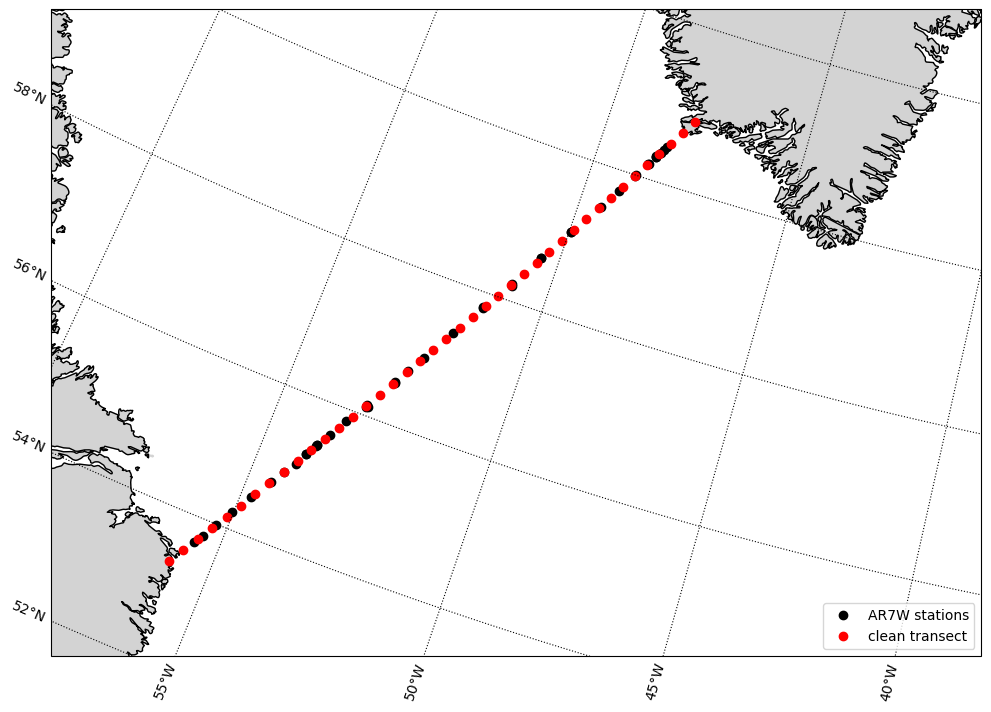

In [4]:
# Plot stations and clean transect
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': crs.LambertConformal(-20, 50)})
ax.set_extent([-60, -40, 55, 60])
ax.coastlines(resolution='10m')
ax.add_feature(feature.LAND, color='lightgray')
gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=range(-60, -39, 5), x_inline=False,
    ylocs=range(52, 63, 2), y_inline=False,
)
gl.top_labels, gl.right_labels = False, False
ax.plot(lon, lat, 'ko', transform=crs.PlateCarree(), label='AR7W stations')
ax.plot(lons, lats, 'ro', transform=crs.PlateCarree(), label='clean transect')
ax.legend(loc=4)

In [ ]:
save_transect('WOCE AR7W', lons, lats)

**Denmark Strait, Iceland-Faroe-Scotland**

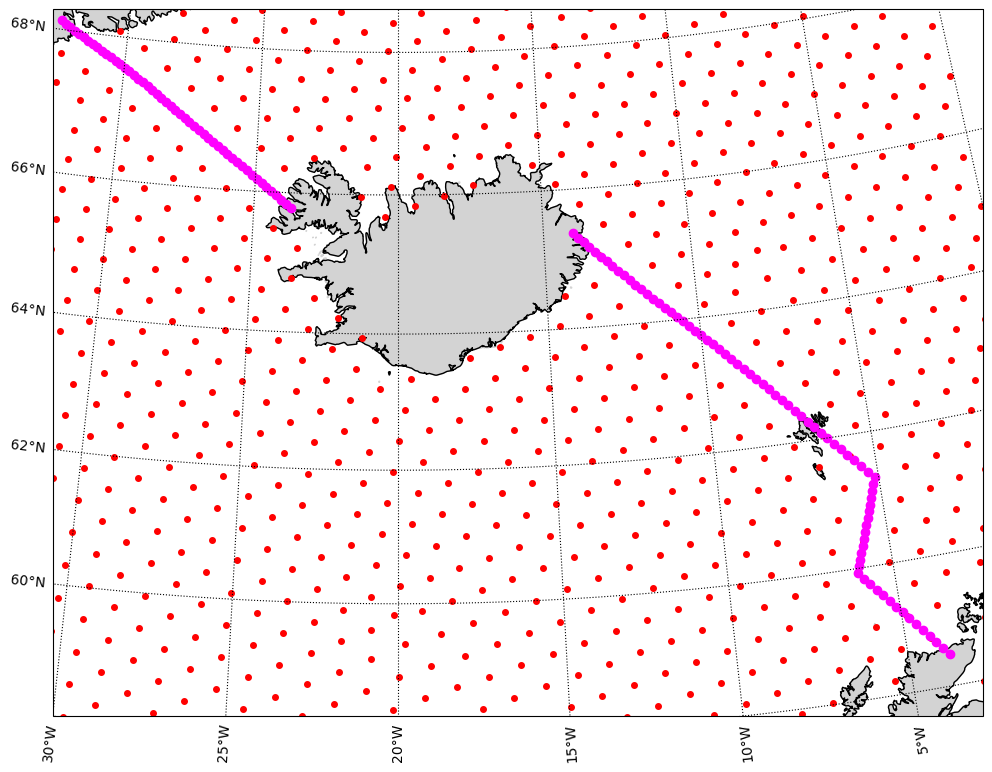

In [59]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': crs.LambertConformal(-20, 65)})
bbox = [-30, -3, 58, 68]
ax.set_extent(bbox)
ax.coastlines(resolution='10m')

# Load paths dict from yaml
with open(f'../yaml/paths_LR.yaml', 'r') as f:
    paths = yaml.safe_load(f)

# Load mesh variables
mesh = xr.open_dataset(paths['meshfile'])
lonCell = np.rad2deg(mesh.lonCell.values) - 360
latCell = np.rad2deg(mesh.latCell.values)

# Create index inside bbox
index, = np.where((lonCell > bbox[0]-10) & (lonCell < bbox[1]+10) & (latCell > bbox[2]-1) & (latCell < bbox[3]+1))

# Plot cell centers
ax.plot(lonCell[index], latCell[index], 'ro', markersize=4, transform=crs.PlateCarree())

# Denmark Strait
index = [105333, 106662, 29014, 106238, 104395, 27034, 104392, 48691, 116556]
x, y = lonCell[index], latCell[index]
f = interp1d(x, y, fill_value='extrapolate')
lons = np.linspace(-32.5, -23.7, 50)
lats = f(lons)
ax.plot(lons, lats, 'o', color='magenta', transform=crs.PlateCarree())
save_transect('Denmark Strait', lons, lats)

# ------- Iceland-Faroe-Scotland -----------
lons = []
lats = []

index = [115103, 127745, 46627, 52756, 66894, 82228, 133948, 170114, 98960, 8663, 8558, 8272]
x, y = lonCell[index], latCell[index]
f = interp1d(x, y, fill_value='extrapolate')
xi = np.linspace(-14, x[-1], 50)
yi = f(xi)
lons.append(xi[:-1])
lats.append(yi[:-1])

index = [6681, 7487, 7852, 8272]
x, y = lonCell[index], latCell[index]
f = interp1d(x, y, fill_value='extrapolate')
xi = np.linspace(x[0], x[-1], 15)
yi = f(xi)
xi, yi = xi[::-1], yi[::-1]
lons.append(xi[:-1])
lats.append(yi[:-1])

index = [6681, 59290, 89755, 47682]
x, y = lonCell[index], latCell[index]
f = interp1d(x, y, fill_value='extrapolate')
xi = np.linspace(x[0], -3.8, 15)
yi = f(xi)
lons.append(xi)
lats.append(yi)

lons = np.hstack(lons)
lats = np.hstack(lats)

ax.plot(lons, lats, 'o', color='magenta', transform=crs.PlateCarree())
save_transect('Iceland-Faroe-Scotland', lons, lats)

# ------------------------------------------

# Add gridlines
ax.add_feature(feature.LAND, color='lightgray')
gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=range(-30, 1, 5), x_inline=False,
    ylocs=range(58, 70, 2), y_inline=False,
)
gl.top_labels, gl.right_labels = False, False

***

### Build transect masks

In [63]:
mask_path = '/pscratch/sd/b/bmoorema/maskfiles/'

In [60]:
# Transects to aggregate
names = [
    'WOCE AR7W',
    'Denmark Strait',
    'Iceland-Faroe-Scotland',
    'OSNAP section East',
    'OSNAP section West',
]

# Read subbasins into merged feature collection
gf = GeometricFeatures()
fc = gf.read('ocean', 'transect', names)

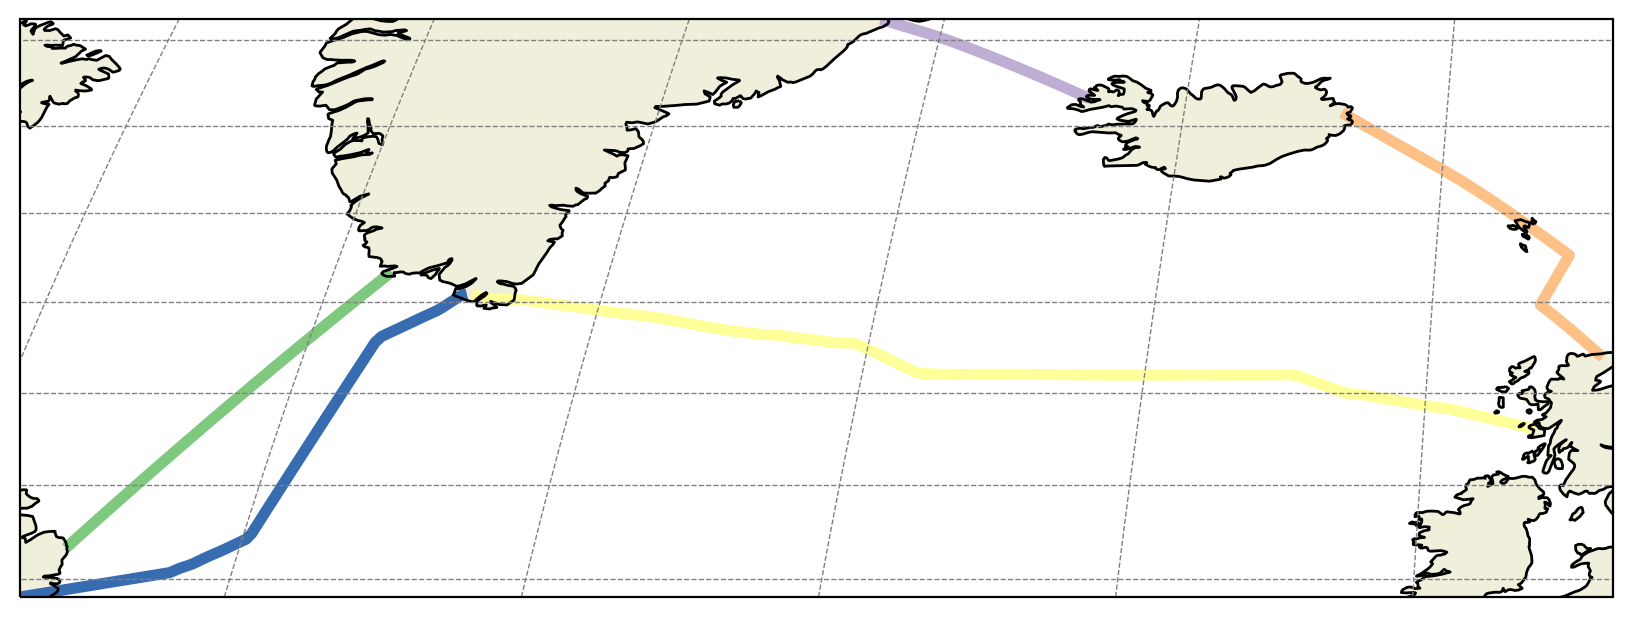

In [61]:
# Plot transects
fig = fc.plot('robin', figsize=(10, 4))

In [64]:
# Write combined transects to geojson
fc.to_geojson(mask_path + 'NAmodewatertransects.geojson')

Now at the command line, run the following
```
compute_mpas_transect_masks -m MESH_FILE_NAME -g GEOJSON_FILE_NAME --add_edge_sign -o MASK_FILE_NAME
```

***

### Masking and regions

[Predefined regions](https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data/ocean/region) are available from the MPAS [geometric features](http://mpas-dev.github.io/geometric_features/stable/quick_start.html) package in `geojson` format. The `geometric_features` package provides an interface to accessing and manipulating these regions. Below is an example of aggregating a region containing the North Atlantic areas of mode water formation.

In [2]:
mask_path = '/pscratch/sd/b/bmoorema/maskfiles/'

In [3]:
# Subbasins to aggregate
names = [
    'Baffin Bay',
    'Bay of Biscay',
    'Caribbean Sea',
    'Celtic Sea',
    'Greenland Sea',
    'Gulf of Mexico',
    'Gulf of St-Lawrence',
    'Iceland Basin',
    'Irminger Sea',
    'Labrador Sea',
    'North Atlantic Ocean',
    'North Sea',
    'Norwegian Sea',
    'Rockall Trench',
]

# Read subbasins into merged feature collection
gf = GeometricFeatures()
fc = gf.read('ocean', 'region', names)

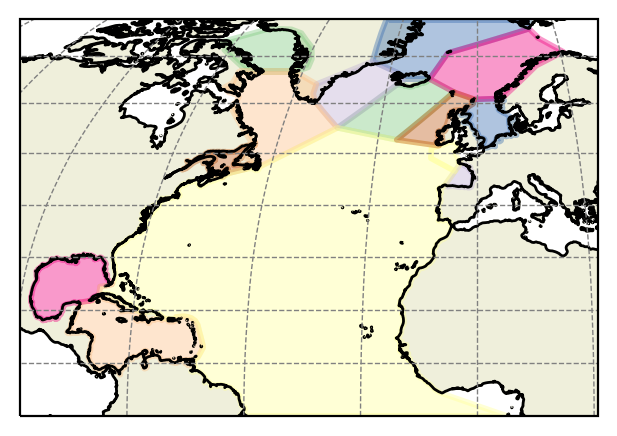

In [4]:
# Plot merged subbasins
fig = fc.plot('robin', figsize=(4, 4))

In [5]:
# Combine merged basins to single basin
fc = fc.combine('North Atlanic Ocean')

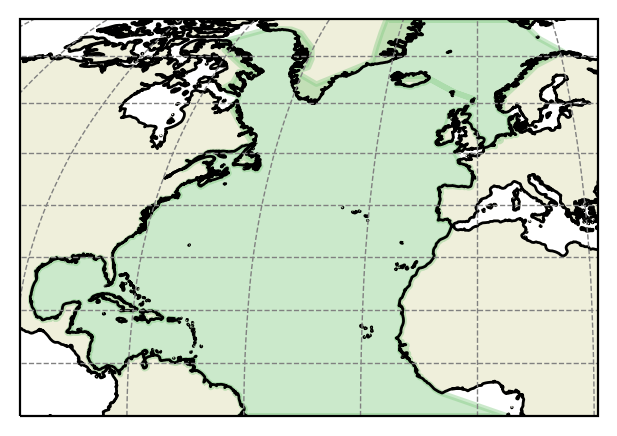

In [6]:
# Plot single basin
fig = fc.plot('robin', figsize=(4, 4))

In [5]:
# Write combined subbasins to geojson
fc.to_geojson(mask_path + 'NAmodewaterregions.geojson')

From here, I run `MpasMaskCreator.x` at command line with an MPAS-O grid file and `NAmodewater.geojson` as inputs. Could also be done in Python with `mpas_tools.mesh.conversion.mask`, but needs to be done with `compass` environment loaded in the shell since a subprocess to `MpasMaskCreator.x` is called.

***

### Applying a mask to MPAS-Ocean results

The output of `MpasMaskCreator.x` was a netcdf file containing several mask variables (I named mine `NAmodewater_maskfile.nc`). Next I open this file along with a grid file and a results file to apply the mask. I'm using `EC30to60E2r2`.

In [8]:
# Load coordinates
gridfile = '/global/cfs/cdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
with xr.open_dataset(gridfile) as ds:
    lon, lat = [np.rad2deg(ds[name].values) for name in ('lonCell', 'latCell')]
lon[lon > 180] = lon[lon > 180] - 360

# Load mask
with xr.open_dataset(mask_path + 'NAmodewater_maskfile.nc') as ds:
    mask = ds.regionCellMasks[:, 0].values.astype(bool)

# Load MPAS-O temperature
results_path = '/global/cfs/cdirs/m4259/E3SMv2_1/20220715.submeso.piControl.ne30pg2_EC30to60E2r2.chrysalis/ocn/hist/'
fn = '20220715.submeso.piControl.ne30pg2_EC30to60E2r2.chrysalis.mpaso.hist.am.timeSeriesStatsMonthly.0001-01-01.nc'
with xr.open_dataset(results_path + fn) as ds:
    T = ds.timeMonthly_avg_activeTracers_temperature[0, :, 0].values

# Mask variables
lon, lat, T = lon[mask], lat[mask], T[mask]

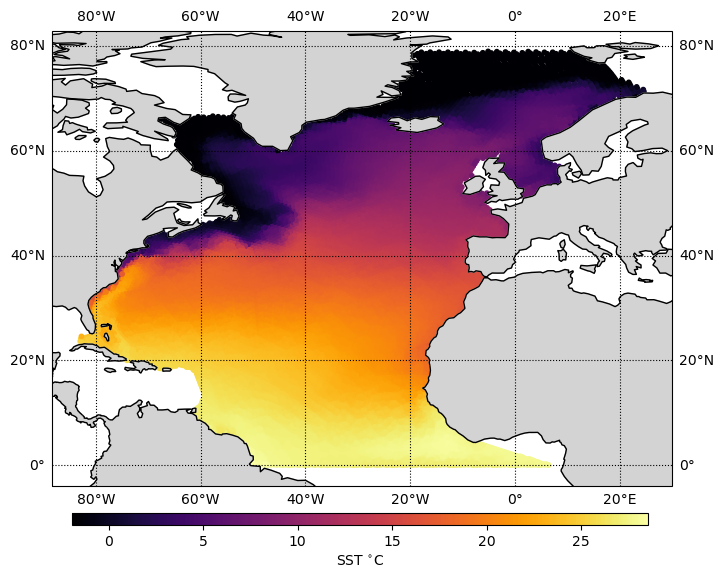

In [12]:
# Plot temperature
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': crs.PlateCarree()})
ax.add_feature(feature.LAND, color='lightgray', zorder=1)
ax.coastlines(zorder=1)
ax.gridlines(linestyle=':', color='k', draw_labels=True)
c = ax.scatter(lon, lat, s=10, c=T, transform=crs.PlateCarree(), cmap='inferno', zorder=0)
cax = fig.add_axes([0.15, 0.05, 0.72, 0.02])
fig.colorbar(c, cax=cax, label='SST $^{\\circ}$C', orientation='horizontal')